In [35]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


### Utility Functions


### Data Collection
- Import the data from Kaggle [Santander Customer Transaction Prediction Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/data)
- Visualize the data: 
    - Check the size and type of data.
- Convert data to practical formats


In [8]:
# Download the dataset first to see what files are available
import os
dataset_path = kagglehub.dataset_download("lakshmi25npathi/santander-customer-transaction-prediction-dataset")

print(f"Dataset downloaded to: {dataset_path}")
print("\nFiles in the dataset:")
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(f"  - {file}")


Dataset downloaded to: C:\Users\Sukhjot Kaur\.cache\kagglehub\datasets\lakshmi25npathi\santander-customer-transaction-prediction-dataset\versions\1

Files in the dataset:
  - test.csv
  - train.csv


In [9]:
dataset_path

'C:\\Users\\Sukhjot Kaur\\.cache\\kagglehub\\datasets\\lakshmi25npathi\\santander-customer-transaction-prediction-dataset\\versions\\1'

In [10]:
import pandas as pd
df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

In [11]:
df.shape

(200000, 202)

In [12]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


Check data types

In [14]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns

In [15]:
non_numeric_cols

Index(['ID_code'], dtype='object')

### Data Processing

- Data cleaning
    - Fill in missing values (empty or NaN) or drop their rows
    - Fix or Remove outliers
- Feature selection
    - Drop non relevant columns
- Feature engineering
    - Possibly discretize continuous features
    - Decompose features (e.g., categorical, date/time)
    - Add promising feature transformations (e.g., log(x), x^2)
    - Aggregate features into promising new features
- Normalization

In [16]:
#Check empty values in each column
empty = df.isna().sum()
print(empty[empty>0])
# Show rows with any null values
df[df.isnull().any(axis=1)]

Series([], dtype: int64)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199


In [17]:
df['target'].value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

In [18]:
# Remove the ID_code column
df = df.drop(columns=['ID_code'])
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [19]:
total_outliers = 0

# Detect outliers using the IQR method

outlier_indices = set()

for col in df.columns.drop('target'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_idx = df[outlier_mask].index.tolist()
    
    #print(f"Column: {col}, Outliers detected: {len(outlier_idx)}")
    
    # Add indices to the set (automatically removes duplicates)
    outlier_indices.update(outlier_idx)
    total_outliers += len(outlier_idx)
print(f"Total outliers detected across all columns: {total_outliers}")
print(f"Total unique rows with outliers: {len(outlier_indices)}")

# (Optional) View the unique outlier rows
outlier_rows = df.loc[list(outlier_indices)]
print(f"\nOutlier rows shape: {outlier_rows.shape}")

Total outliers detected across all columns: 26536
Total unique rows with outliers: 24896

Outlier rows shape: (24896, 201)


In [20]:
# remove outlier rows from the original dataframe
df_cleaned = df.drop(index=outlier_indices)
df_cleaned.shape

(175104, 201)

In [21]:
scorr = df_cleaned.corr(numeric_only=True)
scorr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.050677,0.047490,0.057339,0.011219,0.012102,0.030933,0.067612,-0.002929,0.019535,...,0.054470,0.047234,-0.041799,-0.018757,-0.022275,0.028054,0.024125,-0.036136,-0.051309,0.024045
var_0,0.050677,1.000000,0.000447,0.005772,0.003607,0.001497,0.003588,0.006565,0.002388,0.003740,...,0.002344,0.000057,-0.005919,0.002756,-0.001463,0.002069,0.002914,0.000658,-0.004247,0.002421
var_1,0.047490,0.000447,1.000000,0.002469,-0.000130,0.001733,-0.000727,0.002896,0.001547,0.003268,...,0.006455,0.003558,-0.001848,0.000736,-0.002533,0.000724,0.000386,-0.004665,-0.005277,0.002958
var_2,0.057339,0.005772,0.002469,1.000000,0.000771,0.000612,0.000792,0.000188,-0.001774,0.001454,...,-0.000375,0.001336,-0.002770,0.002097,0.002122,0.000584,0.004006,0.002382,0.000207,0.004883
var_3,0.011219,0.003607,-0.000130,0.000771,1.000000,0.000156,0.003662,-0.000779,0.001929,0.003534,...,-0.000231,0.001728,-0.002122,0.001135,-0.000593,0.002108,-0.001852,0.001307,-0.003154,-0.000276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028054,0.002069,0.000724,0.000584,0.002108,0.005189,-0.001078,0.000565,0.002112,0.000198,...,0.003629,0.002050,-0.003227,-0.003516,-0.000303,1.000000,0.002843,-0.002592,-0.000202,0.002546
var_196,0.024125,0.002914,0.000386,0.004006,-0.001852,-0.000160,0.001153,0.006531,0.000535,-0.003881,...,-0.001792,0.001177,-0.003472,-0.006053,-0.003678,0.002843,1.000000,-0.001325,-0.000204,0.001853
var_197,-0.036136,0.000658,-0.004665,0.002382,0.001307,-0.000746,-0.001695,-0.004202,0.004578,-0.004864,...,-0.005261,0.000397,-0.001156,0.005578,0.001027,-0.002592,-0.001325,1.000000,0.000251,0.005727
var_198,-0.051309,-0.004247,-0.005277,0.000207,-0.003154,-0.000949,-0.000902,-0.001469,0.000850,0.004268,...,-0.000754,0.001345,0.004206,0.001747,0.003350,-0.000202,-0.000204,0.000251,1.000000,-0.005660


In [22]:
np.fill_diagonal(scorr.values, 0)
top_pairs = scorr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_4_pairs = top_pairs.head(10)
print("Top 4 correlated pairs:\n", top_4_pairs)

Top 4 correlated pairs:
 var_81   target     0.080109
var_139  target     0.073132
var_12   target     0.068957
target   var_6      0.067612
var_53   target     0.062227
var_26   target     0.062202
var_110  target     0.061564
target   var_146    0.060576
         var_174    0.059820
         var_76     0.059430
dtype: float64


#### Split test and train sets

In [23]:
X = df_cleaned.drop(columns=['target'])
y = df_cleaned['target']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [49]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### PCA
Reduce dimensions

In [50]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(X_train_pca.shape)

(131328, 190)


### Model Selection

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred = rf_model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [51]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_pca, y_train)
y_pred_lr = lr_model.predict(X_test_pca)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     39500
           1       0.66      0.25      0.36      4276

    accuracy                           0.91     43776
   macro avg       0.79      0.62      0.66     43776
weighted avg       0.90      0.91      0.90     43776



In [36]:
pkl.dump(lr_model, open('logistic_regression_model_unbalanced.pkl', 'wb'))

In [29]:
# I want to use tsne for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_pca)
X_test_tsne = tsne.fit_transform(X_test_pca)

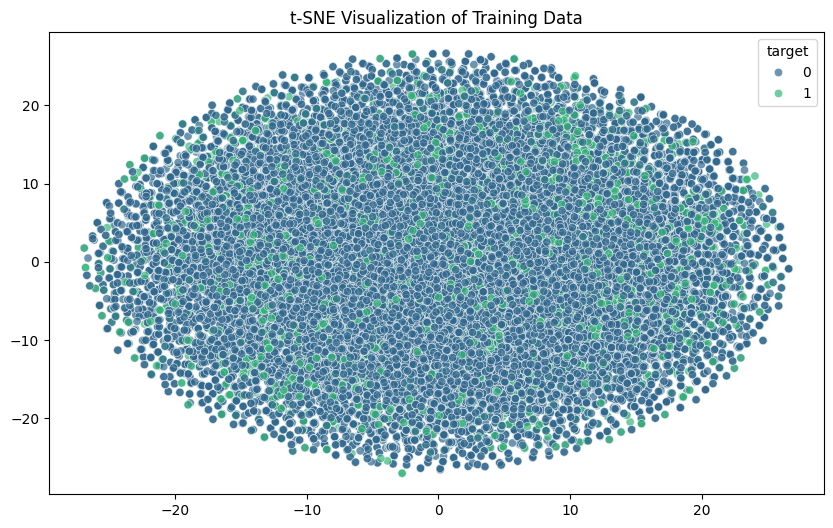

In [33]:
# plot the tsne results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_test, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Training Data')  
plt.show()

In [37]:
# let's try knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_pca, y_train)
y_pred_knn = knn_model.predict(X_test_pca)
print(classification_report(y_test, y_pred_knn))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     39500
           1       0.50      0.00      0.00      4276

    accuracy                           0.90     43776
   macro avg       0.70      0.50      0.48     43776
weighted avg       0.86      0.90      0.86     43776



### Hyperparameter Tuning & Cross-Validation
We will use GridSearchCV to tune hyperparameters for Random Forest, Logistic Regression, and KNN, and compare their F1 scores using cross-validation.

In [38]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1 = make_scorer(f1_score)

In [ ]:
# Random Forest hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=skf, scoring=f1, n_jobs=-1)
rf_grid.fit(X_train_pca, y_train)
print('Best RF F1:', rf_grid.best_score_)
print('Best RF Params:', rf_grid.best_params_)

In [39]:
# Logistic Regression hyperparameter tuning
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=skf, scoring=f1, n_jobs=-1)
lr_grid.fit(X_train_pca, y_train)
print('Best LR F1:', lr_grid.best_score_)
print('Best LR Params:', lr_grid.best_params_)

Best LR F1: 0.40805644781582073
Best LR Params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


In [52]:
# KNN hyperparameter tuning
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
from sklearn.neighbors import KNeighborsClassifier
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=skf, scoring=f1, n_jobs=-1)
knn_grid.fit(X_train_pca, y_train)
print('Best KNN F1:', knn_grid.best_score_)
print('Best KNN Params:', knn_grid.best_params_)

KeyboardInterrupt: 

### Model Comparison & Final Selection
Compare the best F1 scores from each model and select the one with the highest score. Retrain the best model on the full training set if needed.

In [ ]:

# Faster Alternative Models - LightGBM
from lightgbm import LGBMClassifier
lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.05, 0.1],
    'class_weight': [None, 'balanced']
}
lgb_grid = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), lgb_params, cv=skf, scoring=f1, n_jobs=-1)
lgb_grid.fit(X_train_pca, y_train)
print('Best LightGBM F1:', lgb_grid.best_score_)
print('Best LightGBM Params:', lgb_grid.best_params_)


In [ ]:

# LinearSVC - Fast alternative to kernel SVM
from sklearn.svm import LinearSVC
lsvc_params = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}
lsvc_grid = GridSearchCV(LinearSVC(random_state=42, max_iter=2000), lsvc_params, cv=skf, scoring=f1, n_jobs=-1)
lsvc_grid.fit(X_train_pca, y_train)
print('Best LinearSVC F1:', lsvc_grid.best_score_)
print('Best LinearSVC Params:', lsvc_grid.best_params_)


In [59]:

# Naive Bayes - Very fast and good for binary classification
from sklearn.naive_bayes import GaussianNB
nb_grid = GridSearchCV(GaussianNB(), {}, cv=skf, scoring=f1, n_jobs=-1)
nb_grid.fit(X_train_pca, y_train)
y_pred_nb = nb_grid.predict(X_test_pca)
print(classification_report(y_test, y_pred_nb))
print('Best Naive Bayes F1:', nb_grid.best_score_)



              precision    recall  f1-score   support

           0       0.93      0.99      0.96     39500
           1       0.69      0.29      0.41      4276

    accuracy                           0.92     43776
   macro avg       0.81      0.64      0.68     43776
weighted avg       0.90      0.92      0.90     43776

Best Naive Bayes F1: 0.43834435801703864


In [62]:

# SGDClassifier - Fast, scalable alternative
from sklearn.linear_model import SGDClassifier

sgd_grid = SGDClassifier(random_state=42, max_iter=1000)
sgd_grid.fit(X_train_pca, y_train)
sgd_y_pred = sgd_grid.predict(X_test_pca)
print(classification_report(y_test, sgd_y_pred))
# print('Best SGD F1:', sgd_grid.best_score_)
# print('Best SGD Params:', sgd_grid.best_params_)


              precision    recall  f1-score   support

           0       0.91      0.99      0.95     39500
           1       0.66      0.13      0.22      4276

    accuracy                           0.91     43776
   macro avg       0.79      0.56      0.59     43776
weighted avg       0.89      0.91      0.88     43776




### Summary & Best Model Selection
Compare all model F1 scores and select the best one for final evaluation.


In [ ]:

# Compile all results
results = {
    'Logistic Regression': lr_grid.best_score_,
    'LightGBM': lgb_grid.best_score_,
    'LinearSVC': lsvc_grid.best_score_,
    'Naive Bayes': nb_grid.best_score_,
    'SGD Classifier': sgd_grid.best_score_,
    'KNN': knn_grid.best_score_
}

best_model_name = max(results, key=results.get)
best_f1 = results[best_model_name]

print("\n" + "="*50)
print("MODEL COMPARISON (CV F1 Scores)")
print("="*50)
for model, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:25} : {score:.4f}")
print("="*50)
print(f"BEST MODEL: {best_model_name} with F1: {best_f1:.4f}")
print("="*50)
